<a href="https://colab.research.google.com/github/emmGuides/Machine-Learning/blob/main/%5BHW4%5D_GuidesEmmanuel_HW4_(v2_0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Machine Learning - Naive Bayes Classification of Spam emails

Guides, Emmanuel Tarek Shayne <br/> 2019-51020

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn
import sklearn.metrics

In [2]:
# This notebook was done in Colab since my laptop 
# cannot handle the amount of data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# extract data from data_hw4.zip from my personal Drive. This zipfile just contains the data folder.
from zipfile import ZipFile
zipLoc = './drive/MyDrive/data_hw4.zip'
file_name = zipLoc
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Data extraction done')

Data extraction done


In [4]:
# get labels for train and test
# arrays to use
labelsArray = []
train_ref = []
train_labels = []
test_labels = []

# open labels file as list
with open('/content/data/labels') as file:
    labelsArray = file.readlines()

# remove '\n' in each entry
for i in range(len(labelsArray)):
    word = labelsArray[i] 
    labelsArray[i] = word[:len(word)-1]

# get references for training set
for i in range(71):
    if i < 10:
        train_ref.append(f"/data/00{i}")
    else:
        train_ref.append(f"/data/0{i}")

# split spam/ham labels into train and test 
for i in labelsArray:
    if any(j in i for j in train_ref):
        train_labels.append(i)
    else:
        test_labels.append(i)
        
print(f"Length of train labels: {len(train_labels)}")
print(f"Length of test labels: {len(test_labels)}")

Length of train labels: 21300
Length of test labels: 16522


In [5]:
separator = " "
classification_array = []
email_array = []

# for training
# iterate through all lines in train_labels: get classification and location for each email
for i in train_labels:
    
    # get classification and location from each train_label element
    classification, separator, location = i.partition(separator)
    
    # clean location to be used
    location = location[3:]
    
    # open location and read files
    with open(location, "r", errors='ignore') as currFile:
        content = currFile.read()
        
        # add emails and classifications to arrays
        email_array.append(content)
        classification_array.append(classification)
        
        # close file
        currFile.close()
        
    

In [6]:
test_classification_array = []
test_email_array = []

# for testing
# iterate through all lines in test_labels: get classification and location for each email
for i in test_labels:
    
    # get classification and location from each train_label element
    classification, separator, location = i.partition(separator)
    
    # clean location to be used
    location = location[3:]
    
    # open location and read files
    with open(location, "r", errors='ignore') as currFile:
        content = currFile.read()
        
        # add emails and classifications to arrays
        test_email_array.append(content)
        test_classification_array.append(classification)
        
        # close file
        currFile.close()

In [7]:
# check lengths
print(f"Length of classification_array(train) :{len(classification_array)}")
print(f"Length of email_array(train) :{len(email_array)}")

print(f"\nLength of classification_array(test) :{len(test_classification_array)}")
print(f"Length of email_array(test) :{len(test_email_array)}")

Length of classification_array(train) :21300
Length of email_array(train) :21300

Length of classification_array(test) :16522
Length of email_array(test) :16522


In [8]:
# read stopwords.txt
stopWords = []
with open('/content/data/stop_words.txt') as file:
    stopWords = file.readlines()

for i in range(len(stopWords)):
    word = stopWords[i] 
    stopWords[i] = word[:len(word)-1]
stopWords[:10]

['a',
 'able',
 'about',
 'above',
 'abst',
 'accordance',
 'according',
 'accordingly',
 'across',
 'act']

In [9]:
# for mulipart emails
import email
def multipart_email(email_as_string):
    body = ""
    mail = email.message_from_string(email_as_string)
    if mail.is_multipart():
        for part in mail.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True)  # decode
                break
    # not multipart - i.e. plain text, no attachments, keeping fingers crossed
    else:
        body = mail.get_payload(decode=True)
        
    try:
        body = body.decode()
    except:
        try:
            body = body.decode('latin-1')
        except:
            pass
    return(body)

print(f"Multipart email body example:\n\n{multipart_email(email_array[1103])}")

Multipart email body example:

Sorry for all the header garbage...  Trying to find the right channel.



In [10]:
# getting email body, if return type is not string (did not get email body), pass on to multipart email function
def get_emailBody(str_message):
    message = email.message_from_string(str_message)
    returnVal = ''
    try:
        for payload in message.get_payload():
            returnVal = payload.get_payload()
    except:
        returnVal = message.get_payload()
        
    if(type(returnVal) != str):
        returnVal = multipart_email(str_message)
    return str(returnVal)
        
print(f"Getting Email body example:\n{get_emailBody(email_array[1]).strip()}")

Getting Email body example:
LUXURY  WATCHES - BUY YOUR OWN ROLEX  FOR ONLY  $219!                                                        
                                               
  Rolex :: Cartier ::  Bvlgari  ::  Frank Muller  ::  Patek  Philippe :: Vacheron Constantin                   
   A.  Lange  & Sohne  ::  Audemars  Piguet  :: Jaeger-Lecoultre  ::  IWC  :: Officine  Panerai                                                    
 Breitling ::  Omega ::  Tag  Heuer                                   
                       
   Exapmle:                 
 ROLEX  Full 18K Gold  Daytona  for MEN -  only  $269!                                      
                                                 
    - Fast delivery                       
     -  The lowest prices  in the world                                                 
 -  Worldwide shipping                                                                      
                                                            
 

In [11]:
# get all email bodies from train
email_body_array = []
count = 0
for i in email_array:
    email_body_array.append(get_emailBody(i))
    count = count + 1
print(f"Train Email bodies gathered successfully: {count}")

Train Email bodies gathered successfully: 21300


In [12]:
# get all email bodies from test
test_email_body_array = []
count = 0
for i in test_email_array:
    test_email_body_array.append(get_emailBody(i))
    count = count + 1
print(f"Test Email bodies gathered successfully: {count}")

Test Email bodies gathered successfully: 16522


In [13]:
import re # this is regex
HTMLTAGS = re.compile('<.*?>') # define HTML tags

# function to clean one email
def clean_one_email(email_as_string):
    # remove html tags
    email_as_string = re.sub(HTMLTAGS, '', email_as_string)
    # change new lines to just spaces
    email_as_string = email_as_string.replace('\n', ' ')
    # remove nonbreaking space
    email_as_string = email_as_string.replace('nbsp', '')
    # remove non-alphanumeric characters
    email_as_string = [character for character in email_as_string if (character.isalnum() or character == ' ')]
    # remove digits
    email_as_string = [character for character in email_as_string if not(character.isdigit())]
    # join the list to string
    email_as_string = ''.join(email_as_string)
    
    # separate everything to tokens
    email_as_string = email_as_string.lower().split()
    # remove stopwords
    email_as_string = [word for word in email_as_string if not word in stopWords]
    # remove long words
    email_as_string = [word for word in email_as_string if len(word) < 21]
    # join token list to string
    email_as_string = ' '.join(email_as_string)
    
    # return cleaned email body
    return(email_as_string)

In [14]:
# cleaning email bodies and adding to array

def clean_all_email(email_body_array):
    
    clean_email_array = []
    
    for email_as_string in email_body_array:
        clean_email_array.append(clean_one_email(email_as_string))
    
    return clean_email_array

In [15]:
# Showing the difference in email 000, in folder 000 (this is for train)
clean_email_array = clean_all_email(email_body_array)
print(f"Uncleaned email body:\n\n{email_body_array[0]}")
print(f"\nCleaned email body:\n\n{clean_email_array[0]}")

Uncleaned email body:

The mailing list I queried about a few weeks ago is now up and
running.  I have also set up an archive server; see below.  The
following is the official welcome to the list message at the moment.

Joe Buehler

--------------------

This mailing list is for people who desire serious, orthodox
discussion of the Roman Catholic religion.  I assume that it will
cater mainly to Catholics, but everyone else is welcome, provided they
operate within the below guidelines.  My own interests have a
doctrinal bent, but I'm certainly not going to limit this list to just
that sort of discussion.

Having participated in USENET religion groups for about 5 years now,
one of my primary observations about Catholics on the net is that they
do not know their religion very well.  My hope is that this list might
help remedy this problem to some extent.  I would like to make this a
net resource available for Catholics who want to know more about their
religion.

As far as moderation poli

In [16]:
# Also clean test emails
test_clean_email_array = clean_all_email(test_email_body_array)

In [17]:
print(f"Uncleaned email body:\n\n{test_email_body_array[100]}") 
print(f"\nCleaned email body:\n\n{test_clean_email_array[100]}")

Uncleaned email body:

At 03:19 PM 9/4/00 +0100, you wrote:

>Here's a reply from one of our resident wizards.
>
>Hope this helps.

   Thanks, it does.  It is in fact the method I was going to use with the 
exception of the fancy use of cos and sin.  I was going to take an initial 
guess as being the smallest interval between any of the samples, divide 
every time by it and average the errors and adjust the guess based on the 
error and repeat.  I guess the use of the vector arithmetic solves the 
initial phase uncertainty which would represent the lowest error my method 
would come up with.

-jonathan (j.c.f.)

  /"\
  \ /
   X  ASCII RIBBON CAMPAIGN - AGAINST HTML MAIL
  / \

   Look under the sofa cushion; you will be surprised at what you
find.





Cleaned email body:

pm wrote reply resident wizards hope helps fact method going exception fancy cos sin going initial guess smallest interval samples divide time average errors adjust guess based error repeat guess vector arithmetic s

In [18]:
# get unique words
unique = []
wordCounts = dict()
for i in clean_email_array:
    i = i.split()
    for word in i:
        if word in wordCounts:
            wordCounts[word] += 1
        else:
            wordCounts[word] = 1
            
ten_items = {k: wordCounts[k] for k in list(wordCounts)[:10]}

In [19]:
# sort number of words used
sorted_wordCounts = dict(reversed(sorted(wordCounts.items(), key=lambda item: item[1])))

In [20]:
print(f"Remaining word counts after cleaning: {len(wordCounts)}")

Remaining word counts after cleaning: 92550


In [21]:
sorted_ten_K = {k: sorted_wordCounts[k] for k in list(sorted_wordCounts)[:10000]}
keysList = list(sorted_ten_K.keys())

print("Top 10 words:")
for i in range(10):
    print(keysList[i])

Top 10 words:
px
float
will
bb
styledborder
producttable
left
color
board
span


In [22]:
# generate dictionary for dataframe
def generate_dict(keysList, clean_email_array):
    topWordCountList = []
    grand_word_counts = {}

    for topWord in keysList:
        for oneEmail in clean_email_array: # clean_email_array:
            topWordCount = oneEmail.count(topWord)
            topWordCountList.append(topWordCount)
        grand_word_counts[topWord] = topWordCountList
        topWordCountList = []
    return grand_word_counts

In [23]:
# generate dictionary for all 21,300 emails (spam and ham)
grand_word_counts = generate_dict(keysList, clean_email_array)

In [24]:
# add classification in the dictionary
grand_word_counts['spam or ham'] = classification_array

In [25]:
# create spam and ham dict
spam_dict = {}
ham_dict = {}
for i in grand_word_counts.keys():
    spam_dict[i] = []
    ham_dict[i] = []

for i in range(len(classification_array)):
    if grand_word_counts['spam or ham'][i] == 'spam':
        for j in grand_word_counts.keys():
            if(grand_word_counts[j][i] != 0): # if word exists in email, place '1' in cell, else, '0'
              spam_dict[j].append(1)
            else:
              spam_dict[j].append(grand_word_counts[j][i])
    else:
        for j in grand_word_counts.keys():
            if(grand_word_counts[j][i] != 0):
              ham_dict[j].append(1)
            else:
              ham_dict[j].append(grand_word_counts[j][i])
print(f"spam and ham dictionaries created successfully.")

spam and ham dictionaries created successfully.


In [26]:
spam_df = pd.DataFrame.from_dict(spam_dict)
ham_df = pd.DataFrame.from_dict(ham_dict)
print("Spam and Ham dataframes created successfully.")

Spam and Ham dataframes created successfully.


In [27]:
print("Dataframe of all spam emails:")
spam_df

Dataframe of all spam emails:


,px,float,will,bb,styledborder,producttable,left,color,board,span,...,peasant,wooden,feebeeeeeae,eeebfcedeefeec,efbfffee,globally,compmailpine,thy,quarters,spam or ham
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13772,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13773,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
13774,1,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1
13775,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
print("Dataframe of all ham emails:")
ham_df

Dataframe of all ham emails:


,px,float,will,bb,styledborder,producttable,left,color,board,span,...,peasant,wooden,feebeeeeeae,eeebfcedeefeec,efbfffee,globally,compmailpine,thy,quarters,spam or ham
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7518,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7519,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7520,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7521,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


In [29]:
# Compute priors
ham_count = 0
for i in classification_array:
    if i == 'ham':
        ham_count = ham_count + 1
p_ham = ham_count / len(classification_array)
p_spam = 1.0 - p_ham
print(f"P(c = ham) = {p_ham}\nP(c = spam) = {p_spam}")

P(c = ham) = 0.3531924882629108
P(c = spam) = 0.6468075117370893


In [30]:
# Get total spam and ham words
spam_total_count = np.sum(np.sum(spam_df.loc[:, spam_df.columns != 'spam or ham'], axis=1)) 
ham_total_count = np.sum(np.sum(ham_df.loc[:, ham_df.columns != 'spam or ham'], axis=1)) 

print(f"Spam total words: {spam_total_count}\nHam total words: {ham_total_count}")

Spam total words: 2322803
Ham total words: 1402493


In [31]:
def isEmailSpamOrHam(p_ham, p_spam, smooth, word_count, email_body, spam_df, ham_df, spam_total_count, ham_total_count):
    index_checker = 0
    word_spam_score = 0
    word_ham_score = 0
    email_spam_score = 0
    email_ham_score = 0
    
    # For each word in email_body:
    for i in email_body.split():
        try:
            
            # all scores of current word in spam
            word_spam_score = np.sum(spam_df[i])
            
            # all scores of current word in ham
            word_ham_score = np.sum(ham_df[i])
            
            # get P(word|spam)
            p_word_spam = (word_spam_score + smooth) / (spam_total_count + (smooth * word_count))
            email_spam_score = email_spam_score + np.log(p_word_spam)
            
            # get P(word|ham)
            p_word_ham = (word_ham_score + smooth) / (ham_total_count + (smooth * word_count))
            email_ham_score = email_ham_score + np.log(p_word_ham)
            
            # reset word scores
            word_spam_score = 0
            word_ham_score = 0
                
        except:
            # when word is not in the columns since we did cut to 10k
            pass
    
    return 'spam' if (email_spam_score + np.log(p_spam)) > (email_ham_score + np.log(p_ham)) else 'ham'

In [32]:
# Get guesses for the train set into an array
train_class_guess = []
for i in range(len(classification_array)):
    guess = isEmailSpamOrHam(p_ham, p_spam, 1, 10000, clean_email_array[i], spam_df, ham_df, spam_total_count, ham_total_count)
    train_class_guess.append(guess)

In [33]:
# check correct guesses on train set. This is equal to the accuracy.
train_points = 0
for i in range(len(classification_array)):
    if classification_array[i] == train_class_guess[i]:
        train_points = train_points + 1
print(f"Final train score: {train_points}/{len(classification_array)} or {(train_points / len(classification_array)) * 100}%")

Final train score: 20696/21300 or 97.16431924882629%


In [34]:
# predicting test classifications
test_class_guess = []
for i in range(len(test_classification_array)):
    guess_in_test = isEmailSpamOrHam(p_ham, p_spam, 1, 10000, test_clean_email_array[i], spam_df, ham_df, spam_total_count, ham_total_count)
    test_class_guess.append(guess_in_test)

In [35]:
# check correct guesses on test set
test_points = 0
for i in range(len(test_classification_array)):
    if test_classification_array[i] == test_class_guess[i]:
        test_points = test_points + 1
print(f"Final test score: {test_points}/{len(test_classification_array)} or {(test_points / len(test_classification_array)) * 100}%")

Final test score: 15445/16522 or 93.48141871444136%


In [36]:
accuracy_s = sklearn.metrics.accuracy_score(test_classification_array, test_class_guess)
print(f"Accuracy score is: {accuracy_s}, same as the above computation")

Accuracy score is: 0.9348141871444136, same as the above computation


In [37]:
recall_s = sklearn.metrics.recall_score(test_classification_array, test_class_guess, pos_label = 'ham')
print(f"Recall score is: {recall_s}")

Recall score is: 0.8993874141451643


In [38]:
precision_s = sklearn.metrics.precision_score(test_classification_array, test_class_guess, pos_label = 'ham')
print(f"Precision score is: {precision_s}")

Precision score is: 0.9005576208178439


## Using uncleaned email bodies to check:

In [39]:
# using unclean email bodies of test set
# predicting test classifications
unclean_test_class_guess = []
for i in range(len(test_classification_array)):
    unclean_guess_in_test = isEmailSpamOrHam(p_ham, p_spam, 1, 10000, test_email_body_array[i], spam_df, ham_df,  spam_total_count, ham_total_count)
    unclean_test_class_guess.append(unclean_guess_in_test)

In [40]:
unclean_accuracy_s = sklearn.metrics.accuracy_score(test_classification_array, unclean_test_class_guess)
unclean_recall_s = sklearn.metrics.recall_score(test_classification_array, unclean_test_class_guess, pos_label = 'ham')
unclean_precision_s = sklearn.metrics.precision_score(test_classification_array, unclean_test_class_guess, pos_label = 'ham')
print(f"Accuracy score on uncleaned set is: {unclean_accuracy_s}")
print(f"Recall score on uncleaned set is: {unclean_recall_s}")
print(f"Precision score on uncleaned set is: {unclean_precision_s}")

Accuracy score on uncleaned set is: 0.8959569059435903
Recall score on uncleaned set is: 0.9014293669946166
Precision score on uncleaned set is: 0.8034414295168762


Text(0.5, 1.0, 'Accuracy Comparison')

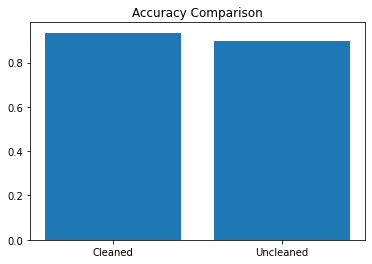

In [41]:
plt.bar(['Cleaned','Uncleaned'], [accuracy_s, unclean_accuracy_s])
plt.title('Accuracy Comparison')

Text(0.5, 1.0, 'Recall Comparison')

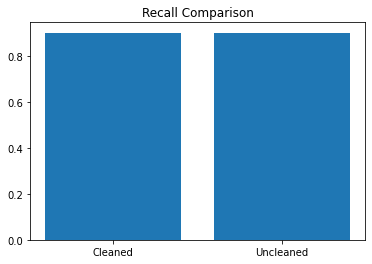

In [42]:
plt.bar(['Cleaned','Uncleaned'], [recall_s, unclean_recall_s])
plt.title('Recall Comparison')

Text(0.5, 1.0, 'Precision Comparison')

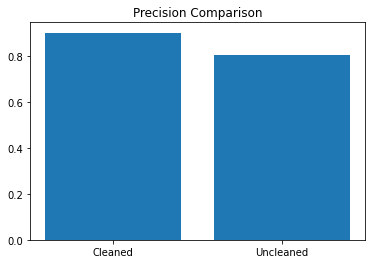

In [43]:
plt.bar(['Cleaned','Uncleaned'], [precision_s, unclean_precision_s])
plt.title('Precision Comparison')

## Testing trimmed set, from 10k words down to 1k

In [44]:
# for trimmed word counts
# trim the "sorted" dictionaries (first 1000 words)
trimmed_spam_dict = {k: spam_dict[k] for k in list(spam_dict)[:1000]}
trimmed_ham_dict = {k: ham_dict[k] for k in list(ham_dict)[:1000]}
print(f"Created trimmed spam and ham dicts with lengths: {len(trimmed_spam_dict)} and {len(trimmed_ham_dict)}")

Created trimmed spam and ham dicts with lengths: 1000 and 1000


In [45]:
# for trimmed word counts
# create dataframes
trimmed_spam_df = pd.DataFrame.from_dict(trimmed_spam_dict)
trimmed_ham_df = pd.DataFrame.from_dict(trimmed_ham_dict)
print("Trimmed Spam and Ham dataframes created successfully.")

Trimmed Spam and Ham dataframes created successfully.


In [46]:
# for trimmed word counts
# Get total spam and ham words
trimmed_spam_total_count = np.sum(np.sum(trimmed_spam_df, axis=1)) 
trimmed_ham_total_count = np.sum(np.sum(trimmed_ham_df, axis=1)) 

print(f"Spam total words: {trimmed_spam_total_count}\nHam total words: {trimmed_ham_total_count}")

Spam total words: 627198
Ham total words: 374360


In [47]:
# for trimmed word counts
# predicting test classifications
trimmed_test_class_guess = []
for i in range(len(test_classification_array)):
    trimmed_guess_in_test = isEmailSpamOrHam(p_ham, p_spam, 1, 10000, test_clean_email_array[i], trimmed_spam_df, trimmed_ham_df, trimmed_spam_total_count, trimmed_ham_total_count)
    trimmed_test_class_guess.append(trimmed_guess_in_test)
print(f"Done. Guess length is : {len(trimmed_test_class_guess)}")

Done. Guess length is : 16522


In [48]:
trimmed_accuracy_s = sklearn.metrics.accuracy_score(test_classification_array, trimmed_test_class_guess)
print(f"Accuracy score is: {trimmed_accuracy_s}, compared to 10k words with {accuracy_s}")

Accuracy score is: 0.9234959448008716, compared to 10k words with 0.9348141871444136


In [49]:
trimmed_recall_s = sklearn.metrics.recall_score(test_classification_array, trimmed_test_class_guess, pos_label = 'ham')
print(f"Recall score is: {trimmed_recall_s}, compared to 10k words with: {recall_s}")

Recall score is: 0.8696862817894933, compared to 10k words with: 0.8993874141451643


In [50]:
trimmed_precision_s = sklearn.metrics.precision_score(test_classification_array, trimmed_test_class_guess, pos_label = 'ham')
print(f"Precision score is: {trimmed_precision_s}, compared to 10k words with: {precision_s}")

Precision score is: 0.8928911759100439, compared to 10k words with: 0.9005576208178439


## Testing k>100

In [51]:
k_100_spam = {}
k_100_ham = {}
for i in grand_word_counts.keys():
  try:
    if np.sum(grand_word_counts[i]) > 100:
      k_100_spam[i] = spam_dict[i]
      k_100_ham[i] = ham_dict[i]
  except:
    pass # for the spam or ham column, which is not numerical 
print(f"k>100 full dictionaries done. Lengths are {len(k_100_spam)} and {len(k_100_ham)}")

k>100 full dictionaries done. Lengths are 4806 and 4806


In [52]:
# k>100 df
k100_spam_df = pd.DataFrame.from_dict(k_100_spam)
k100_ham_df = pd.DataFrame.from_dict(k_100_ham)
print("k>100 Spam and Ham dataframes created successfully.")

k>100 Spam and Ham dataframes created successfully.


In [53]:
# Get total spam and ham words
k100_spam_total_count = np.sum(np.sum(k100_spam_df, axis=1)) 
k100_ham_total_count = np.sum(np.sum(k100_ham_df, axis=1)) 

print(f"Spam total words: {k100_spam_total_count}\nHam total words: {k100_ham_total_count}")

Spam total words: 2220179
Ham total words: 1335842


In [54]:
# predicting test classifications
k100_test_class_guess = []
for i in range(len(test_classification_array)):
    k100_guess_in_test = isEmailSpamOrHam(p_ham, p_spam, 1, 10000, test_clean_email_array[i], k100_spam_df, k100_ham_df, trimmed_spam_total_count, trimmed_ham_total_count)
    k100_test_class_guess.append(k100_guess_in_test)
print(f"Done. Guess length is : {len(k100_test_class_guess)}")

Done. Guess length is : 16522


In [55]:
k100_accuracy_s = sklearn.metrics.accuracy_score(test_classification_array, k100_test_class_guess)
k100_recall_s = sklearn.metrics.recall_score(test_classification_array, k100_test_class_guess, pos_label = 'ham')
k100_precision_s = sklearn.metrics.precision_score(test_classification_array, k100_test_class_guess, pos_label = 'ham')
print(f"Precision score is: {k100_precision_s}, compared to 10k words with: {precision_s}")
print(f"Recall score is: {k100_recall_s}, compared to 10k words with: {recall_s}")
print(f"Accuracy score is: {k100_accuracy_s}, compared to 10k words with {accuracy_s}")

Precision score is: 0.9049594569111824, compared to 10k words with: 0.9005576208178439
Recall score is: 0.8908483385929089, compared to 10k words with: 0.8993874141451643
Accuracy score is: 0.9339063067425252, compared to 10k words with 0.9348141871444136


## Testing k = 50

In [56]:
k_50_spam = {}
k_50_ham = {}
for i in grand_word_counts.keys():
  try:
    if np.sum(grand_word_counts[i]) == 50:
      k_50_spam[i] = spam_dict[i]
      k_50_ham[i] = ham_dict[i]
  except:
    pass # for the spam or ham column, which is not numerical 
print(f"k=50 full dictionaries done. Lengths are {len(k_50_spam)} and {len(k_50_ham)}")

k=50 full dictionaries done. Lengths are 106 and 106


In [57]:
# k=50 df
k50_spam_df = pd.DataFrame.from_dict(k_50_spam)
k50_ham_df = pd.DataFrame.from_dict(k_50_ham)
print("k=50 Spam and Ham dataframes created successfully.")

k=50 Spam and Ham dataframes created successfully.


In [58]:
# Get total spam and ham words
k50_spam_total_count = np.sum(np.sum(k50_spam_df, axis=1)) 
k50_ham_total_count = np.sum(np.sum(k50_ham_df, axis=1)) 

print(f"Spam total words: {k50_spam_total_count}\nHam total words: {k50_ham_total_count}")

Spam total words: 3745
Ham total words: 649


In [59]:
# predicting test classifications
k50_test_class_guess = []
for i in range(len(test_classification_array)):
    k50_guess_in_test = isEmailSpamOrHam(p_ham, p_spam, 1, 10000, test_clean_email_array[i], k50_spam_df, k50_ham_df, trimmed_spam_total_count, trimmed_ham_total_count)
    k50_test_class_guess.append(k50_guess_in_test)
print(f"Done. Guess length is : {len(k50_test_class_guess)}")

Done. Guess length is : 16522


In [60]:
k50_accuracy_s = sklearn.metrics.accuracy_score(test_classification_array, k50_test_class_guess)
k50_recall_s = sklearn.metrics.recall_score(test_classification_array, k50_test_class_guess, pos_label = 'ham')
k50_precision_s = sklearn.metrics.precision_score(test_classification_array, k50_test_class_guess, pos_label = 'ham')
print(f"Precision score is: {k50_precision_s}, compared to 10k words with: {precision_s}")
print(f"Recall score is: {k50_recall_s}, compared to 10k words with: {recall_s}")
print(f"Accuracy score is: {k50_accuracy_s}, compared to 10k words with {accuracy_s}")

Precision score is: 0.8183760683760684, compared to 10k words with: 0.9005576208178439
Recall score is: 0.0710970855763876, compared to 10k words with: 0.8993874141451643
Accuracy score is: 0.6919864423193318, compared to 10k words with 0.9348141871444136


## Testing different Lambda values

These were tested on k>100 spam and ham dataframes to save time since, as compared earlier, the metrics' values compared to all 10k features vary just slightly. This is done to save time and memory needed for processing.

In [84]:
len(test_classification_array)

16522

In [62]:
# for trimmed word counts,
# predicting test classifications on differing smoothing values

def get_ARP_lambda(smoothing):
  returned_guess = []
  for i in range(len(test_classification_array)):
      guess = isEmailSpamOrHam(p_ham, p_spam, smoothing, len(k_100_ham), test_clean_email_array[i], k100_spam_df, k100_ham_df, k100_spam_total_count, k100_ham_total_count)
      returned_guess.append(guess)

  accuracy = sklearn.metrics.accuracy_score(test_classification_array, returned_guess)
  recall = sklearn.metrics.recall_score(test_classification_array, returned_guess, pos_label = 'ham')
  precision = sklearn.metrics.precision_score(test_classification_array, returned_guess, pos_label = 'ham')

  return accuracy, recall, precision

In [88]:
print("We already have lambda 1.0 metric scores for k>100 we calculated earlier:")
print(f"accuracy: {k100_accuracy_s}\nrecall: {k100_recall_s}\nprecision: {k100_precision_s}") 

We already have lambda 1.0 metric scores for k>100 we calculated earlier:
accuracy: 0.9339063067425252
recall: 0.8908483385929089
precision: 0.9049594569111824


In [85]:
# get metrics of lambda 2.0
lambda_2_accuracy, lambda_2_recall, lambda_2_precision = get_ARP_lambda(2)

In [89]:
# get metrics of lambda 0.5
lambda_05_accuracy, lambda_05_recall, lambda_05_precision = get_ARP_lambda(0.5)

In [90]:
# get metrics of lambda 0.1
lambda_01_accuracy, lambda_01_recall, lambda_01_precision = get_ARP_lambda(0.1)

In [91]:
# get metrics of lambda 0.005
lambda_005_accuracy, lambda_005_recall, lambda_005_precision = get_ARP_lambda(0.005)

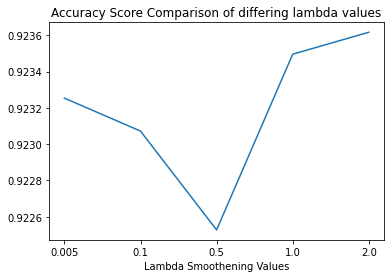

In [92]:
plt.plot(['0.005', '0.1', '0.5', '1.0', '2.0'], [lambda_005_accuracy, lambda_01_accuracy, lambda_05_accuracy, trimmed_accuracy_s, lambda_2_accuracy])
plt.title('Accuracy Score Comparison of differing lambda values')
plt.xlabel('Lambda Smoothening Values')
plt.show()

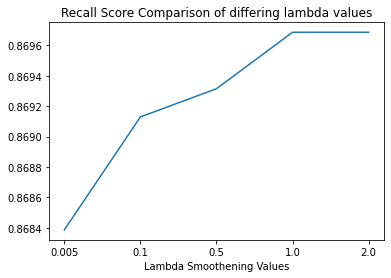

In [93]:
plt.plot(['0.005', '0.1', '0.5', '1.0', '2.0'], [lambda_005_recall, lambda_01_recall, lambda_05_recall, trimmed_recall_s, lambda_2_recall])
plt.title('Recall Score Comparison of differing lambda values')
plt.xlabel('Lambda Smoothening Values')
plt.show()

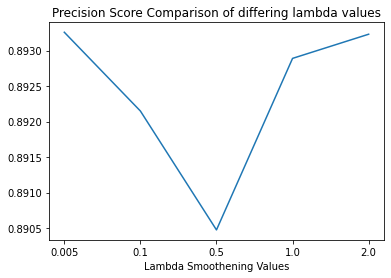

In [94]:
plt.plot(['0.005', '0.1', '0.5', '1.0', '2.0'], [lambda_005_precision, lambda_01_precision, lambda_05_precision, trimmed_precision_s, lambda_2_precision])
plt.title('Precision Score Comparison of differing lambda values')
plt.xlabel('Lambda Smoothening Values')
plt.show()